In [ ]:
#imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


#disabe annoying warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
news_train = 'MINDsmall_train/news.tsv'
#news_test = 'MINDlarge_test/news.tsv'
#news_valid = 'MINDlarge_val/news.tsv'

#entity_embedding.vec ->	The embeddings of entities in news extracted from knowledge graph 
#relation_embedding.vec	->  The embeddings of relations between entities extracted from knowledge graph
#both [ID (retrievable from news dataset: columns) - EMB VALUES]

In [3]:
def load_news_df(path):
    if 'news' in path:
        columns = ['News ID',
                "Category",
                "SubCategory",
                "Title",
                "Abstract",
                "URL",
                "Title Entities",
                "Abstract Entities "]
    
    elif 'behavior' in path:
        columns = ['Impression ID',
                "User ID",
                "Time",
                "History",
                "Impressions"]
    
    df = pd.read_csv(path, sep='\t', header=None, names=columns)
    
    return df

#news_df.shape

In [5]:
train = load_news_df(news_train)
#test = load_news_df(news_test)
#valid = load_news_df(news_valid)
print(train.shape)

(51282, 8)


# EDA
### news

In [6]:
news_df = load_news_df(news_train)
news_df.shape #consider stratified sampling if need to reduce dataset

(51282, 8)

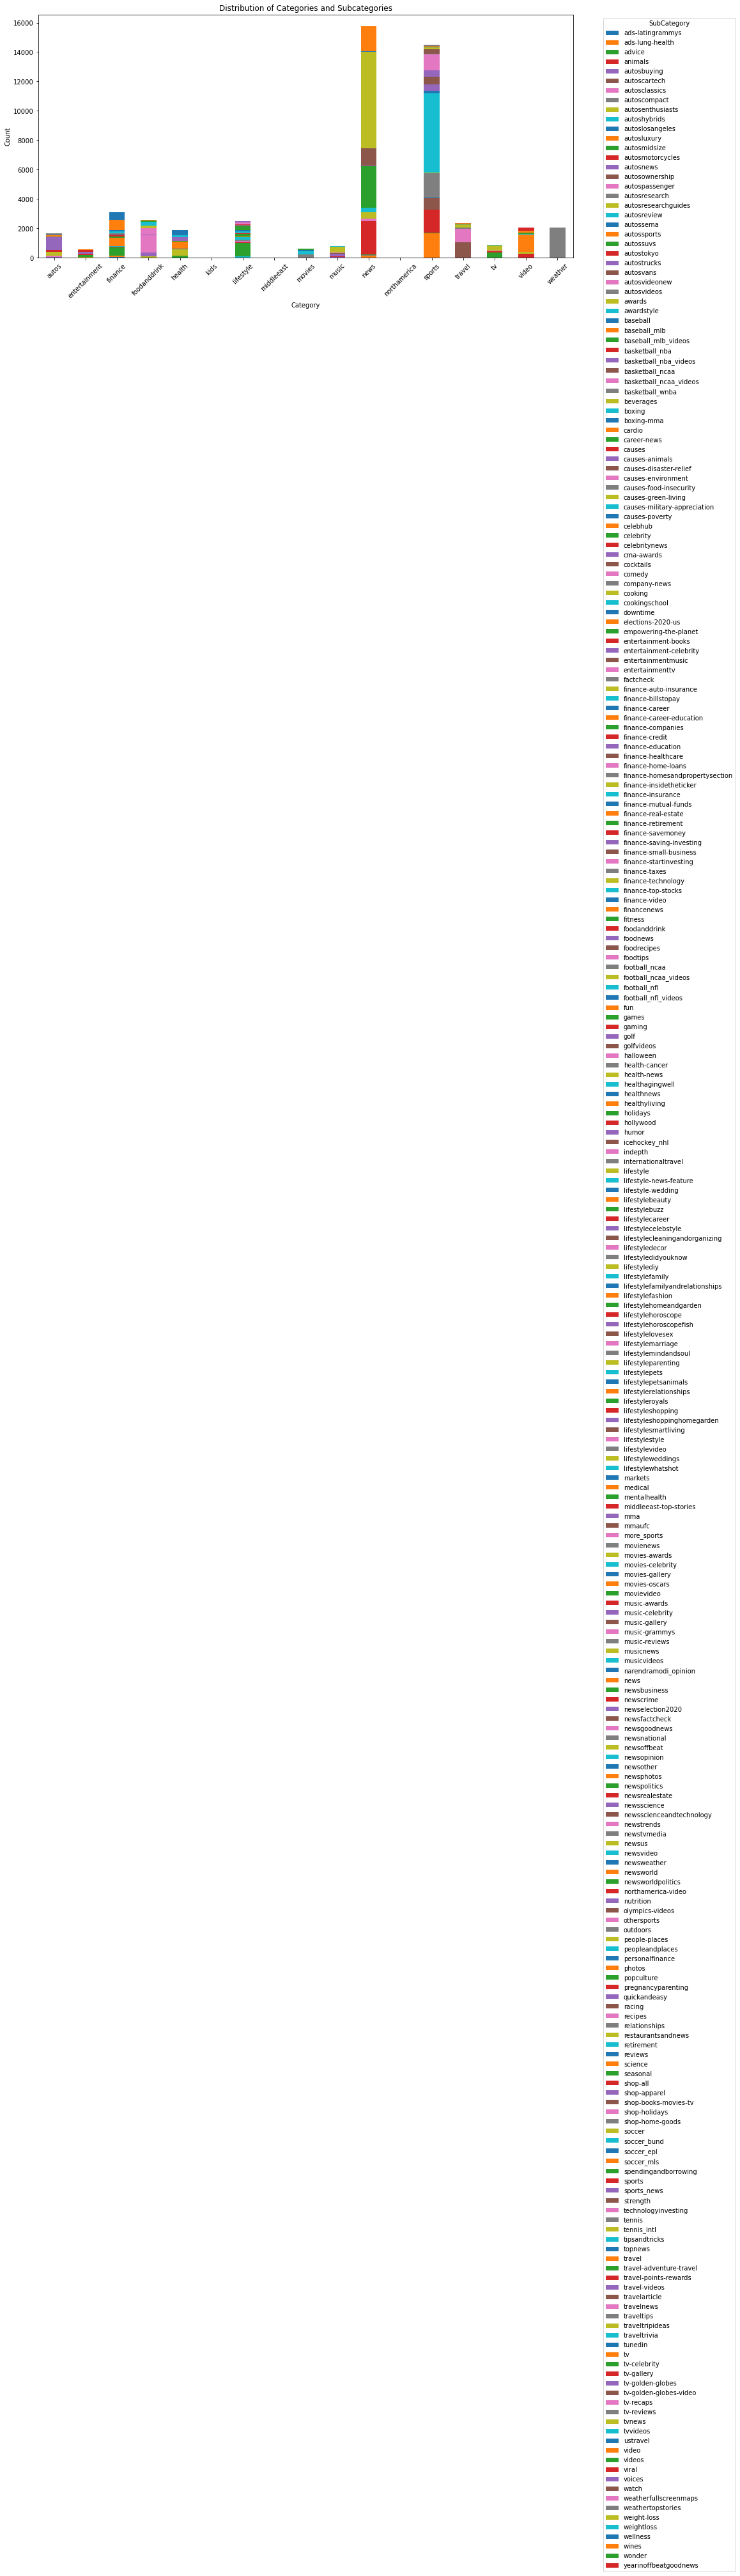

In [7]:

#category & subcategory distribution:
news_df['Category'] = news_df['Category'].astype('category')
news_df['SubCategory'] = news_df['SubCategory'].astype('category')

# Drop columns not needed for this operation
columns_to_keep = ['Category', 'SubCategory']
df_reduced = news_df[columns_to_keep]

# Group and unstack
category_counts = df_reduced.groupby(['Category', 'SubCategory']).size().unstack(fill_value=0)

category_counts.plot(kind='bar', stacked=True, figsize=(15, 7))
plt.title('Distribution of Categories and Subcategories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='SubCategory', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()



In [8]:
missing_values = news_df.isnull().sum()
missing_values #

News ID                  0
Category                 0
SubCategory              0
Title                    0
Abstract              2666
URL                      0
Title Entities           3
Abstract Entities        4
dtype: int64

In [9]:
#remove rows where 'Title Entities' or 'Abstract Entities' are missing (only 6 samples out of +100k)
news_df = news_df.dropna(subset=['Title Entities', 'Abstract Entities '])
missing_values = news_df.isnull().sum()
missing_values

News ID                  0
Category                 0
SubCategory              0
Title                    0
Abstract              2666
URL                      0
Title Entities           0
Abstract Entities        0
dtype: int64

In [10]:
#display an example with missing abstract
sample = news_df[news_df['Abstract'].isnull()].iloc[6]
sample #the url does not lead to anything

News ID                                                          N26766
Category                                                          autos
SubCategory                                                   autosnews
Title                 Tanker truck bursts into flames following cras...
Abstract                                                            NaN
URL                       https://assets.msn.com/labs/mind/AAJ44wZ.html
Title Entities                                                       []
Abstract Entities                                                    []
Name: 214, dtype: object

<AxesSubplot:>

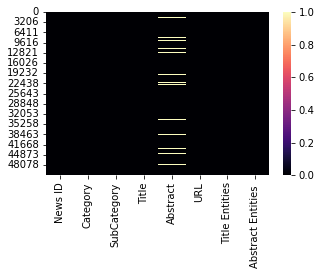

In [11]:
plt.figure(figsize=(5,3))
sns.heatmap(news_df.isnull(), cbar=True, cmap='magma')

In [12]:
news_df = news_df.drop(columns=['URL'])
news_df = news_df.dropna()
news_df.shape


(48612, 7)

In [13]:
unique_categories = news_df['Category'].unique()
unique_subcategories = news_df['SubCategory'].unique()

#print("Categories:", unique_categories)
#print("Subcategories:", unique_subcategories)


list_of_categories = unique_categories.tolist()
list_of_subcategories = unique_subcategories.tolist()
len(list_of_subcategories) 


259

In [14]:
set(list_of_categories).intersection(set(list_of_subcategories))

{'foodanddrink', 'lifestyle', 'news', 'sports', 'travel', 'tv', 'video'}

____________________________________________________
## behaviours

behaviors.tsv:<br> This file records user interactions with news articles. It typically includes user IDs, the time of interaction, the history of news interactions for each user, and the news articles they have clicked on.

`ImpressionID, UserID, Time, History, Impressions` <br>
`1, U1, 11/01/2020 11:30, N1 N2 N3, N4-0 N5-1 N6-0`


ImpressionID: "1" is the unique identifier for this impression.<br>
UserID: "U1" denotes the user.<br>
Time: "11/01/2020 11:30" is the timestamp of the interaction.<br>
History: "N1 N2 N3" are IDs of news articles the user has clicked on before.<br>
Impressions: "N4-0 N5-1 N6-0" shows that articles "N4" and "N6" were not clicked (indicated by "-0"), while "N5" was clicked (indicated by "-1") during this impression.

In [15]:
#look at behaviours.tsv file
behaviours_path = 'MINDsmall_train/behaviors.tsv'

behaviours_df = pd.read_csv(behaviours_path,header=None,sep='\t')
behaviours_df.columns=['Impression ID',
                'User ID',
                "Time of interaction",
                "History",
                "News clicked",
                ]
behaviours_df.head() 

,Impression ID,User ID,Time of interaction,History,News clicked
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


In [18]:
behaviours_df.shape

(156965, 5)

____________________________________________________

In [17]:
missing_values = behaviours_df.isnull().sum()
missing_values #!!!!

Impression ID             0
User ID                   0
Time of interaction       0
History                3238
News clicked              0
dtype: int64

In [19]:
unique_users = behaviours_df['User ID'].nunique()
unique_news = news_df['News ID'].nunique()
print(f"Unique users: {unique_users}, Unique news articles: {unique_news}")

Unique users: 50000, Unique news articles: 48612


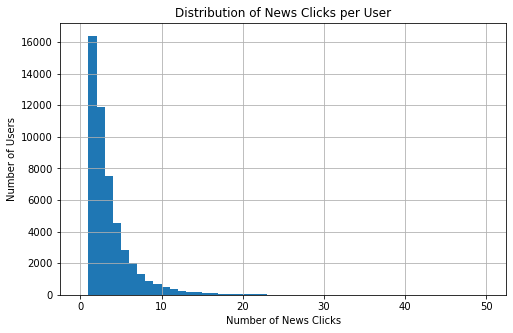

In [20]:
news_clicks_per_user = behaviours_df['User ID'].value_counts()

plt.figure(figsize=(8, 5))
news_clicks_per_user.hist(bins=50, range=(0,50)) 
plt.title('Distribution of News Clicks per User')
plt.xlabel('Number of News Clicks')
plt.ylabel('Number of Users')
plt.show()




In [21]:
behaviours_df['Time of interaction'] = pd.to_datetime(behaviours_df['Time of interaction'])
behaviours_df['Date'] = behaviours_df['Time of interaction'].dt.date
interactions_per_day = behaviours_df['Date'].value_counts().sort_index()

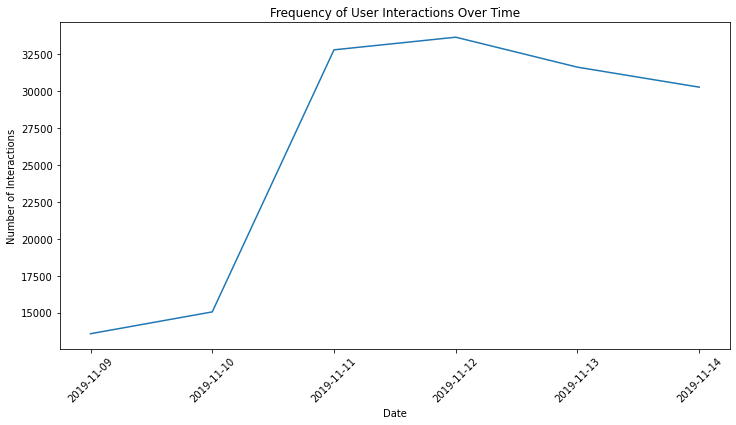

In [22]:
plt.figure(figsize=(12, 6))
interactions_per_day.plot(kind='line')
plt.title('Frequency of User Interactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=45)
plt.show()